# 操作1

In [46]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [49]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [50]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [51]:
from diffusers import DEISMultistepScheduler

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

# 数据准备

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
df = pd.read_csv(  "./mydata/diabetes.csv")
df_input = df[['timestamp', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']]
df_input = df_input.set_index('timestamp')

In [55]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
train_grouper_diabetes = MultivariateGrouper(max_target_dim=8)

test_grouper_diabetes = MultivariateGrouper( max_target_dim=8)

In [56]:
train_time='2020-02-27 04:12:53'
training_data = train_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[:train_time]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[:train_time]}],
     freq = "5min"
    )[0],
])

In [57]:
test_data = test_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[train_time:]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[train_time:]}],
     freq = "5min"
    )[0],
])+test_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[train_time:]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[train_time:]}],
     freq = "5min"
    )[0],
])

In [58]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [59]:
estimator_Diabetes = TimeGradEstimator(
    input_size=7,
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=12,
    context_length=36,
    freq='5min',
    scaling="mean",
    trainer_kwargs=dict(max_epochs=20, accelerator="gpu", devices="1"),
)


# 训练开始

In [60]:
predictor_Diabetes = estimator_Diabetes.train(training_data, num_workers=8)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


INFO: 
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 73.1 K | train | [[1, 1], [1, 1], [1, 36, 6], [1, 36, 7], [1, 36, 7], [1, 12, 6]] | [1, 100, 12, 7]
-------------------------------------------------------------------------------------------------------------------------------------
73.1 K    Trainable params
0         Non-trainable params
73.1 K    Total params
0.292     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 7

Epoch 0: |          | 50/? [00:04<00:00, 10.05it/s, v_num=19, train_loss=0.367]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.36684 (best 0.36684), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:04<00:00, 10.08it/s, v_num=19, train_loss=0.208]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.20839 (best 0.20839), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:04<00:00, 10.15it/s, v_num=19, train_loss=0.174]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.17433 (best 0.17433), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:04<00:00, 10.11it/s, v_num=19, train_loss=0.163]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.16258 (best 0.16258), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:04<00:00, 10.28it/s, v_num=19, train_loss=0.155]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 0.15480 (best 0.15480), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:04<00:00, 10.64it/s, v_num=19, train_loss=0.147]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' reached 0.14714 (best 0.14714), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:05<00:00,  9.99it/s, v_num=19, train_loss=0.142]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 350: 'train_loss' reached 0.14232 (best 0.14232), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:04<00:00, 10.06it/s, v_num=19, train_loss=0.137]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 400: 'train_loss' reached 0.13650 (best 0.13650), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:04<00:00, 10.07it/s, v_num=19, train_loss=0.132]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 450: 'train_loss' reached 0.13232 (best 0.13232), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:04<00:00, 10.02it/s, v_num=19, train_loss=0.129]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 500: 'train_loss' reached 0.12940 (best 0.12940), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:04<00:00, 10.03it/s, v_num=19, train_loss=0.126]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 550: 'train_loss' reached 0.12602 (best 0.12602), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:04<00:00, 10.04it/s, v_num=19, train_loss=0.123]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 600: 'train_loss' reached 0.12309 (best 0.12309), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:04<00:00, 10.09it/s, v_num=19, train_loss=0.119]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 650: 'train_loss' reached 0.11874 (best 0.11874), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:04<00:00, 10.09it/s, v_num=19, train_loss=0.118]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 700: 'train_loss' reached 0.11792 (best 0.11792), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:04<00:00, 10.09it/s, v_num=19, train_loss=0.118]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 750: 'train_loss' reached 0.11754 (best 0.11754), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:04<00:00, 10.02it/s, v_num=19, train_loss=0.113]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 800: 'train_loss' reached 0.11328 (best 0.11328), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:04<00:00, 10.06it/s, v_num=19, train_loss=0.113]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:05<00:00,  9.98it/s, v_num=19, train_loss=0.111]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 900: 'train_loss' reached 0.11082 (best 0.11082), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_19/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:04<00:00, 10.01it/s, v_num=19, train_loss=0.114]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:04<00:00, 10.01it/s, v_num=19, train_loss=0.112]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1000: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 50/? [00:05<00:00,  9.89it/s, v_num=19, train_loss=0.112]


In [67]:
forecast_it_Diabetes, ts_it_Diabetes = make_evaluation_predictions(dataset=test_data,
                                                 predictor=predictor_Diabetes,
                                                 num_samples=10)


In [68]:
forecasts_Diabetes = list(forecast_it_Diabetes)
targets_Diabetes = list(ts_it_Diabetes)

In [79]:
len(forecasts_Diabetes)

2

In [78]:
forecasts_Diabetes[0].samples.shape

(10, 12, 7)

In [80]:
targets_Diabetes

[                         0         1         2         3         4         5  \
 2020-02-26 21:42 -0.647059  0.135678 -0.278689 -0.737374  0.000000 -0.332340   
 2020-02-26 21:47 -0.764706 -0.256281  0.000000  0.000000  0.000000  0.000000   
 2020-02-26 21:52 -0.176471 -0.165829  0.278689 -0.474747 -0.832151 -0.126677   
 2020-02-26 21:57  0.000000  0.015075  0.065574 -0.434343  0.000000 -0.266766   
 2020-02-26 22:02 -0.411765  0.376884  0.770492  0.000000  0.000000  0.454545   
 2020-02-26 22:07 -0.764706  0.105528  0.213115 -0.414141 -0.704492 -0.034277   
 2020-02-26 22:12  0.529412  0.065327  0.180328  0.090909  0.000000  0.090909   
 2020-02-26 22:17 -0.764706  0.005025  0.114754 -0.494949 -0.832151  0.147541   
 2020-02-26 22:22  0.764706  0.366834  0.147541 -0.353535 -0.739953  0.105812   
 2020-02-26 22:27 -0.882353  0.075377  0.114754 -0.616162  0.000000 -0.210134   
 2020-02-26 22:32 -0.882353 -0.195980 -0.098361  0.000000  0.000000 -0.430700   
 2020-02-26 22:37 -0.529412 

In [ ]:
targets_Diabetes[0]

,0,1,2,3,4,5,6,7,8,9,...,360,361,362,363,364,365,366,367,368,369
2014-03-19 09:00,141.705063,153.191483,67.242355,133.418579,104.571068,33.790920,475.764343,501.163147,6.930185,1033.755249,...,78.754578,22.525848,96.228241,221.521042,512.218628,30.427631,2645.533203,157.960831,255.664383,90.417603
2014-03-19 10:00,141.129028,183.510635,67.808609,145.566925,105.979965,32.998943,474.459351,505.944122,6.930185,1439.873413,...,91.575089,39.697193,85.589943,234.951462,527.540222,31.250000,2715.417969,174.873276,269.400696,91.349739
2014-03-19 11:00,119.815666,153.723404,77.576447,150.895142,104.571068,38.806759,500.559296,518.829285,6.930185,2207.805908,...,166.483521,38.220089,84.139267,233.656952,537.218628,33.305920,2866.714600,192.549927,293.102753,89.858315
2014-03-19 12:00,139.400925,181.914886,76.019249,155.370850,102.692551,34.318901,489.932892,545.332336,6.930185,2659.282715,...,186.446884,48.005909,82.688591,248.220062,546.077148,34.950657,2949.567627,191.394012,304.784241,94.519012
2014-03-19 13:00,125.576035,136.170212,70.781425,156.862747,97.056984,39.070751,487.136475,570.324768,6.673512,3614.979004,...,202.564102,55.760708,73.500969,247.896439,517.065918,36.184212,2719.020264,181.405533,309.592468,93.214020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-01 20:00,107.718895,152.659576,91.449600,99.744247,91.891045,38.542767,633.109619,680.906372,14.373716,4494.725586,...,292.857147,73.855247,177.466156,341.909393,791.969482,76.891449,2772.334229,182.941635,354.229462,123.974648
2014-09-01 21:00,112.903229,164.893616,84.796150,95.055412,95.178459,39.334740,571.961243,624.864075,12.320329,3559.071777,...,198.534805,67.946823,243.230179,336.407776,778.271729,78.125000,2815.562012,177.565277,339.818481,118.381805
2014-09-01 22:00,71.428574,155.319153,69.648926,88.874680,94.239197,39.070751,514.727844,514.848938,11.550308,3053.797363,...,134.798538,66.469719,242.746613,314.886719,647.684875,76.069077,2882.564941,147.204300,249.825348,97.501862
2014-09-01 23:00,58.755760,138.297867,50.537937,66.922424,95.178459,39.070751,451.528717,291.752258,11.550308,1808.016846,...,122.710625,58.530281,221.470016,249.676376,503.159149,70.723686,3152.017334,111.459297,149.880142,70.842651


# 画出预测图

Diabetes


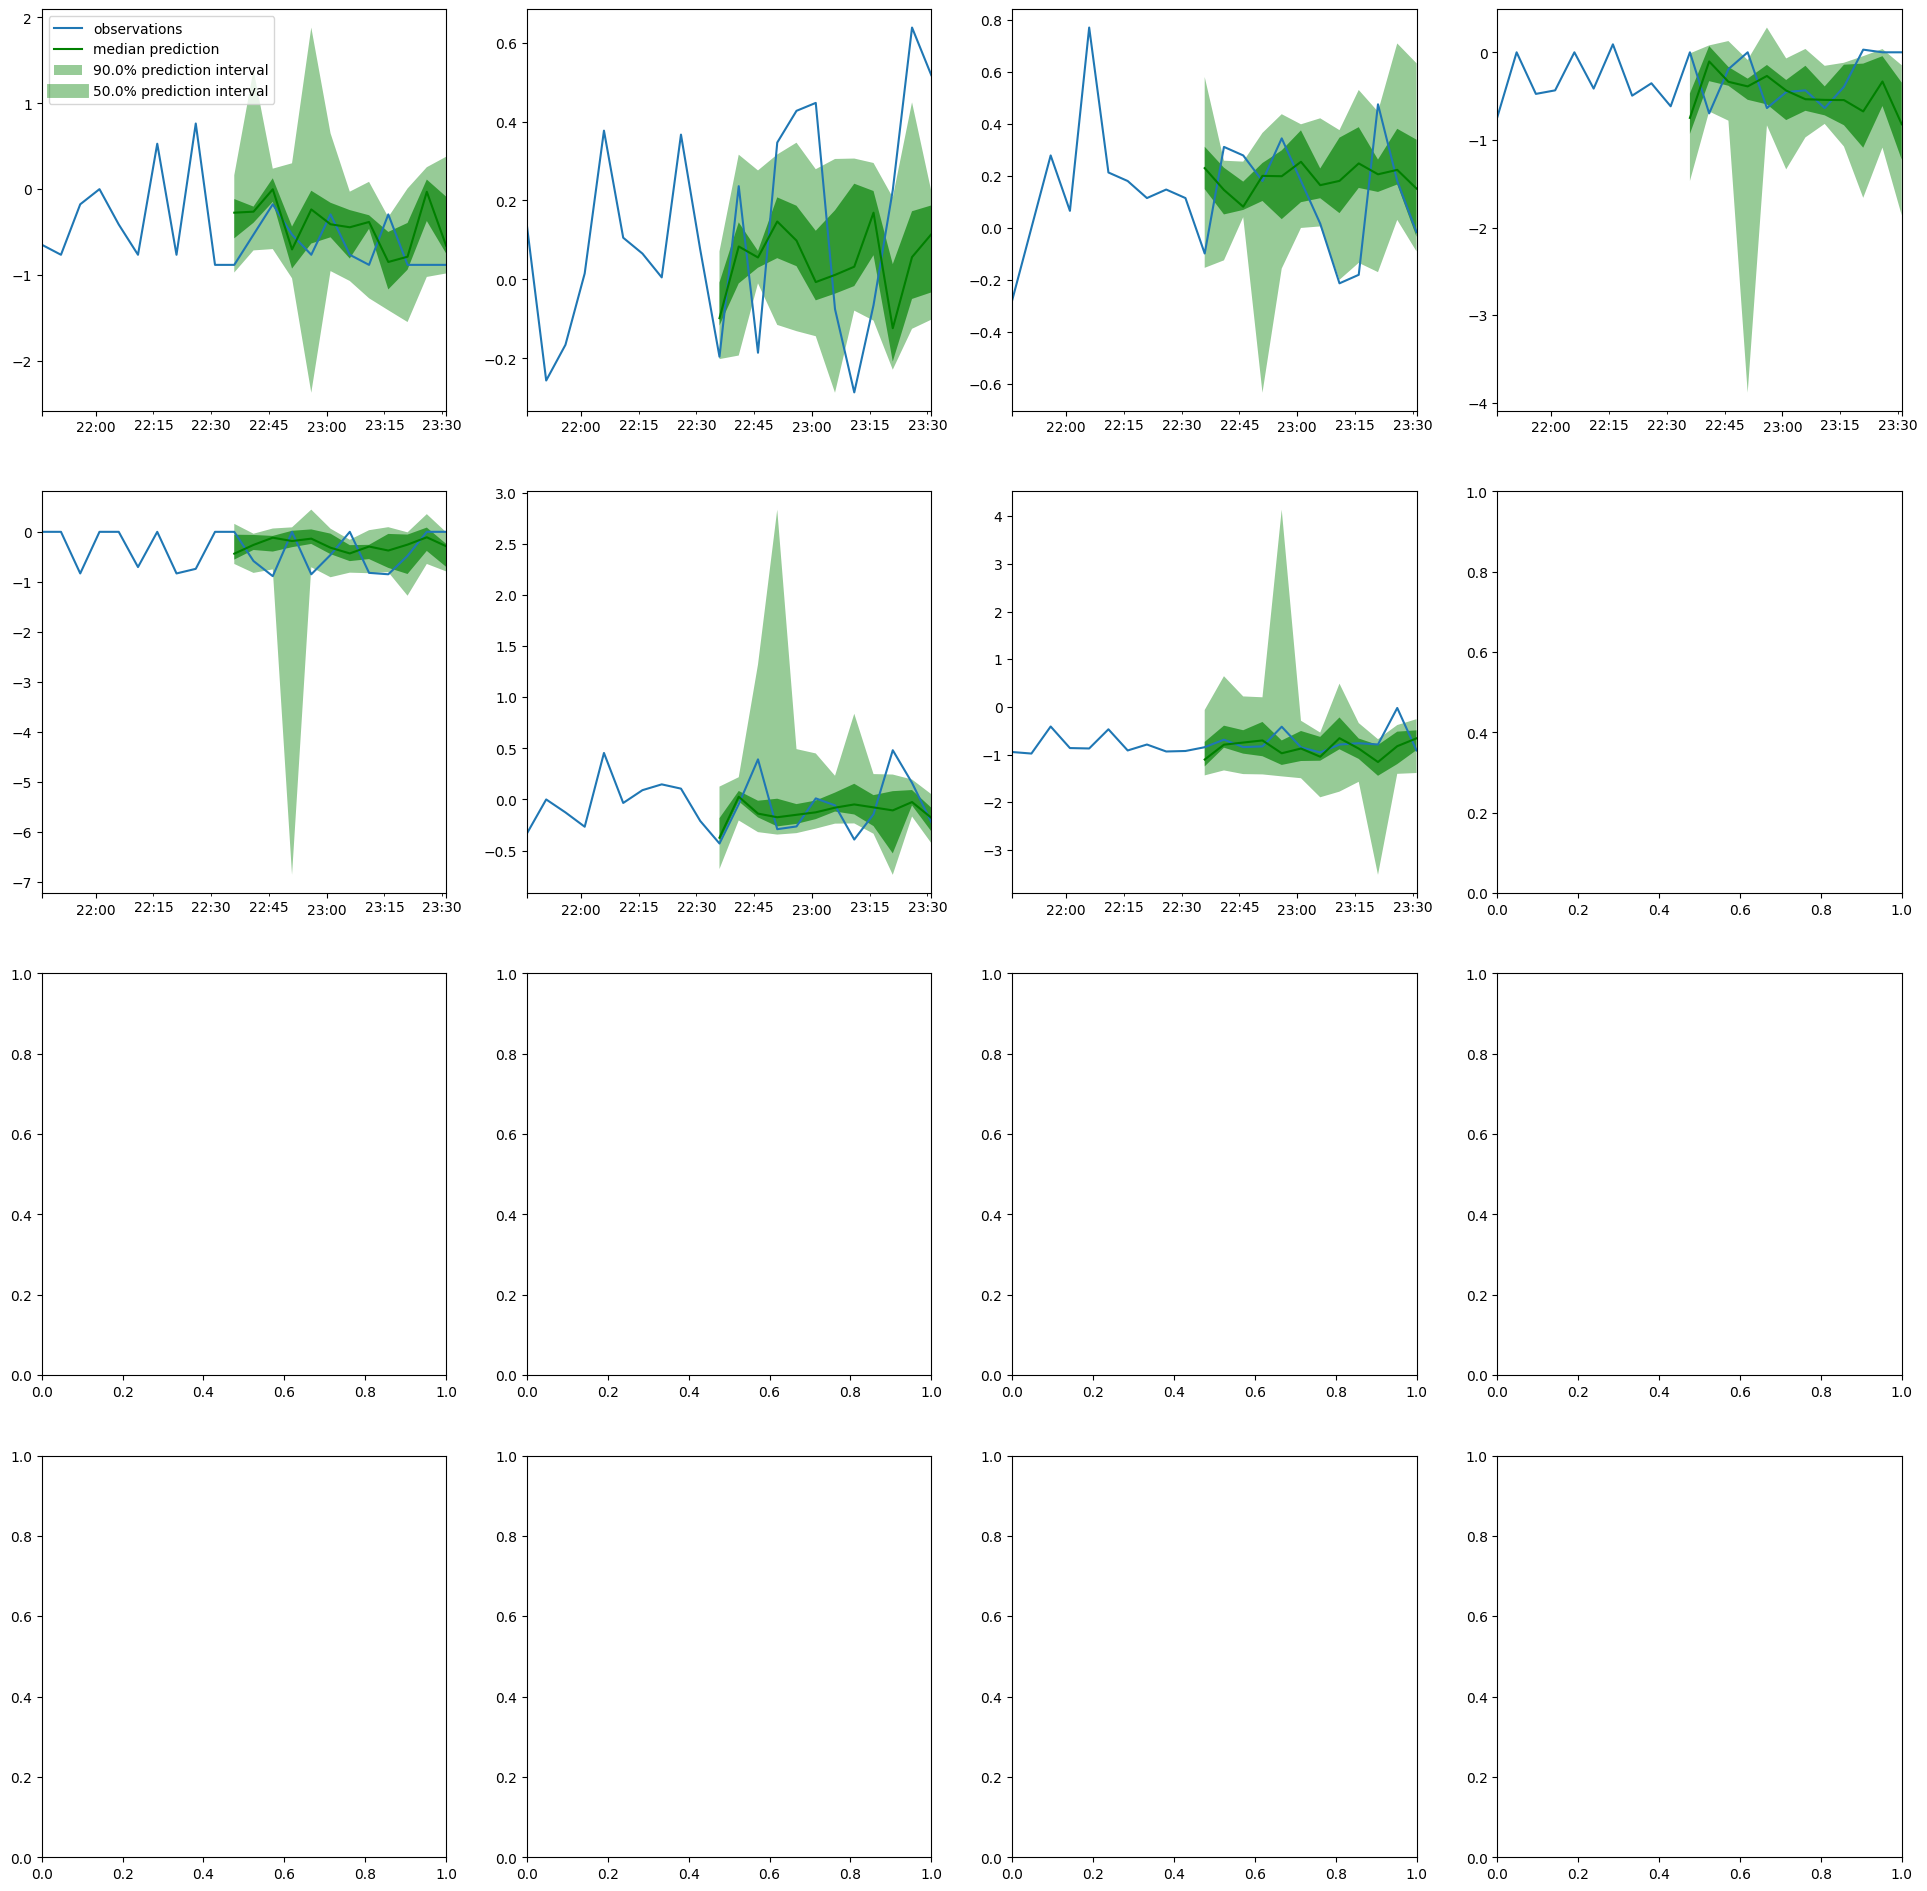

In [63]:
print("Diabetes")

plot(
    target=targets_Diabetes[0],
    forecast=forecasts_Diabetes[0],
    prediction_length=12,
)
plt.show()

# 评估

In [64]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [65]:
agg_metric_Diabetes, item_metrics_Diabetes = evaluator(targets_Diabetes, forecasts_Diabetes, num_series=len(test_data))


Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 2it [00:00, 61.58it/s]
Running evaluation: 2it [00:00, 117.51it/s]
Running evaluation: 2it [00:00, 127.54it/s]
Running evaluation: 2it [00:00, 114.63it/s]
Running evaluation: 2it [00:00, 121.42it/s]
Running evaluation: 2it [00:00, 116.03it/s]
Running evaluation: 2it [00:00, 114.82it/s]
Running evaluation: 2it [00:00, 116.47it/s]


In [66]:
print("Diabetes Results")
print("CRPS:", agg_metric_Diabetes["mean_wQuantileLoss"])
print("ND:", agg_metric_Diabetes["ND"])
print("NRMSE:", agg_metric_Diabetes["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_Diabetes["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_Diabetes["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_Diabetes["m_sum_NRMSE"])

Electricity Results
CRPS: 0.5447965637919815
ND: 0.7130718796833904
NRMSE: 0.9145155317308664

CRPS-Sum: 0.35923830007284413
ND-Sum: 0.456409765051571
NRMSE-Sum: 0.6911615789437333
